**The whole point of intuition is: let every token look at every other token, decide which ines are relevantm and then gather information from the relevant ones. Q, K and V are simplpy a mathematically relevant way of doing that. Evrything revolves around relevance and information retrieval**

In [53]:
import torch
import numpy as np
import torch.nn.functional as F
from torch.testing import assert_close
import matplotlib.pyplot as plt
import math

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q, K, V: (..., T, d_k / d_v) tensors
    mask: optional  boolean or float mask broadcastable to (..., T, T)
        - boolean: True = keep, False = mask out
        - float: added directly to the scores (eg 0 or 1e-9

    returns:
        Y    (..., T, d_v)
        attn (..., T, T)
    """
    # 1. Compute scaled scores: S = Q K^T / sqrt(d_k)
    d_k = Q.shape[-1]
    # (..., T, d_k) @ (..., d_k, T) -> (..., T, T)
    scores = Q @ K.transpose(-2,-1) / (d_k**0.5)

    # 2. Add mask 
    if mask is not None:
        if mask.dtype == torch.bool:
            # boolean mask: False entries get a large negative score
            scores = scores.masked_fill(~mask, -1e9)
        else:
            # float mask: assumed to be additive (eg 0 or -1e9)
            scores = scores + mask

    # 3. Softmax over last dimension to get attention weights
    attn = F.softmax(scores, dim=-1) # (..., T, T)

    # 4. Weighted sum of values: Y = AV
    # (..., T, T) @ (..., T, d_v) -> (..., T, d_v)
    Y = attn @ V
    return Y, attn

In [54]:
Q = np.array([
    [1,0],
    [0,1],
    [1,1]
], dtype=float)

K = np.array([
    [1,0],
    [1,1],
    [0,1]
], dtype=float)

V = np.array([
    [1,0],
    [0,2],
    [3,1]
], dtype=float)

In [55]:
Q_t = torch.tensor(Q, dtype=torch.float32).unsqueeze(0) # shape (1, T, d_k)
K_t = torch.tensor(K, dtype=torch.float32).unsqueeze(0)
V_t = torch.tensor(V, dtype=torch.float32).unsqueeze(0)
T = Q_t.size(1)

Y, attn = scaled_dot_product_attention(Q_t,K_t,V_t)

print("Scores (QK^T / sqrt(dk)):\n", (Q_t @ K_t.transpose(-2,-1)) / (Q_t.size(-1)**0.5))
print("\nAttention weights A:\n", attn)
print("\nOutput Y:\n",Y)

Scores (QK^T / sqrt(dk)):
 tensor([[[0.7071, 0.7071, 0.0000],
         [0.0000, 0.7071, 0.7071],
         [0.7071, 1.4142, 0.7071]]])

Attention weights A:
 tensor([[[0.4011, 0.4011, 0.1978],
         [0.1978, 0.4011, 0.4011],
         [0.2483, 0.5035, 0.2483]]])

Output Y:
 tensor([[[0.9944, 1.0000],
         [1.4011, 1.2033],
         [0.9930, 1.2552]]])


***Causal mask version with heatmap***

Causal attention matrix A (masked):
 tensor([[1.0000, 0.0000, 0.0000],
        [0.3302, 0.6698, 0.0000],
        [0.2483, 0.5035, 0.2483]])


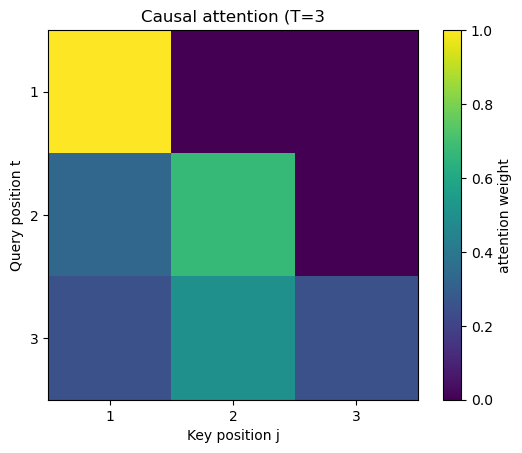

In [56]:
# Lower triangular causal mask: shape (1, T, T)
causal_mask = torch.tril(torch.ones(T, T, dtype=torch.bool)).unsqueeze(0)

Y_causal, A_causal = scaled_dot_product_attention(Q_t, K_t, V_t, mask=causal_mask)

print("Causal attention matrix A (masked):\n", A_causal[0])

plt.figure()
plt.imshow(A_causal[0].detach().numpy())
plt.title("Causal attention (T=3")
plt.xlabel("Key position j")
plt.ylabel("Query position t")
plt.xticks(range(T), [1,2,3])
plt.yticks(range(T),[1,2,3])
plt.colorbar(label="attention weight")
plt.show()
      

***expected hand computed scores***

In [75]:
import math
import torch
from torch.testing import assert_close

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q, K, V: (..., T, d_k / d_v) tensors
    mask: optional  boolean or float mask broadcastable to (..., T, T)
        - boolean: True = keep, False = mask out
        - float: added directly to the scores (eg 0 or 1e-9

    returns:
        Y    (..., T, d_v)
        attn (..., T, T)
    """
    # 1. Compute scaled scores: S = Q K^T / sqrt(d_k)
    d_k = Q.shape[-1]
    # (..., T, d_k) @ (..., d_k, T) -> (..., T, T)
    scores = Q @ K.transpose(-2,-1) / (d_k**0.5)

    # 2. Add mask 
    if mask is not None:
        if mask.dtype == torch.bool:
            # boolean mask: False entries get a large negative score
            scores = scores.masked_fill(~mask, -1e9)
        else:
            # float mask: assumed to be additive (eg 0 or -1e9)
            scores = scores + mask

    # 3. Softmax over last dimension to get attention weights
    attn = F.softmax(scores, dim=-1) # (..., T, T)

    # 4. Weighted sum of values: Y = AV
    # (..., T, T) @ (..., T, d_v) -> (..., T, d_v)
    Y = attn @ V
    return Y, attn

def test_scaled_dot_product_attention():
    # construct a tiny example
    Q_np = [
        [1.0,0.0],
        [0.0,1.0],
        [1.0,1.0],
    ]

    K_np = [
        [1.0,0.0],
        [1.0,1.0],
        [0.0,1.0],
    ]

    V_np = [
        [1.0,0.0],
        [0.0,2.0],
        [3.0,1.0],
    ]

    # convert to tensors with batch dim B = 1: shape (1, T, d_k/d_v)
    Q = torch.tensor(Q_np, dtype=torch.float32).unsqueeze(0) # (1, 3, 2)
    K = torch.tensor(K_np, dtype=torch.float32).unsqueeze(0) # (1, 3, 2)
    V = torch.tensor(V_np, dtype=torch.float32).unsqueeze(0) # (1, 3, 2)
    
    # --- expected hand computed results ---
    
    # QK^T (unscaled)
    expected_scores_unscaled=torch.tensor(
        [[[1.0,1.0,0.0],
          [0.0,1.0,1.0],
          [1.0,2.0,1.0]]],dtype=torch.float32)
    
    # scaled scores S = QK^T / sqrt(d_k), d_k = 2
    expected_S = torch.tensor(
        [[[0.70710678, 0.70710678, 0.0],
          [0.0, 0.70710678, 0.70710678],
          [0.70710678, 0.70710678*2,0.70710678]]], dtype=torch.float32)
    
    expected_A = torch.tensor(
        [[[0.40111209, 0.40111209,0.19777581],
          [0.19777581,0.40111209,0.40111209],
          [0.24825508,0.50348984,0.24825508]]],dtype=torch.float32)
    
    # output Y = A V
    expected_Y = torch.tensor(
        [[[0.99443954, 1.0],
          [1.40111209, 1.20333628],
          [0.99302031, 1.25523477]]],dtype=torch.float32,
    )
    
    # --- Compute using the same formulas as the implementation ---
    
    d_k = Q.shape[-1]
    
    tol=1e-6
    
    
    # Unscaled scores QK^T
    scores_unscaled = Q @ K.transpose(-2,-1) # (1, 3, 3)
    assert torch.allclose(scores_unscaled, expected_scores_unscaled, atol=tol, rtol=tol)
    
    # Scaled scores S
    S = scores_unscaled / math.sqrt(d_k)
    assert torch.allclose(S, expected_S, atol=tol, rtol=tol)
    assert torch.allclose(S, expected_S, atol=tol, rtol=tol)
    assert torch.allclose(S, expected_S, atol=tol, rtol=tol)
    
    # --- Run through the scaled_dot_product_attention ---
    Y, A = scaled_dot_product_attention(Q, K, V, mask=None)
    
    # check attention weights A
    assert torch.allclose(A, expected_A, atol=tol, rtol=tol)
    
    # check final outputs Y
    assert torch.allclose(Y, expected_Y, atol=tol, rtol=tol) 

    print("all tests passed")

In [76]:
test_scaled_dot_product_attention()

all tests passed
